In [1]:
from src.v4.torchengine import AnalyticalSetSympy, FunctionSympy, Function
from src.v4.torchdata import print_formatted_table, load_multiple_files
from scipy.optimize import minimize
import numpy as np
import torch
np.set_printoptions(formatter={'float': lambda x: 
                                f"{x:.3f}".rstrip('0').rstrip('.')})

## Load problem

In [2]:
prob_encoding = (10, 15, 1, 3, 0)
prob_name = str(prob_encoding)
setinfosympy, objective, _, _, symb_str_mapping = (
    load_multiple_files([prob_name], 'polyproblems_v2_med'))
setinfosympy = setinfosympy[prob_name]

FileNotFoundError: [Errno 2] No such file or directory: '../../../applications/data/polyproblems_v2_med.json'

In [ ]:
import re
def extract_number(string):
    return int(re.search(r'\d+', string).group())

# maps x_10 to 10 to simplify our lives a bit
idxrev = {extract_number(str(elt)): elt for elt in 
            symb_str_mapping.values()}
indices = {elt: torch.tensor([i]) for i, elt in 
            idxrev.items()}

In [ ]:
sets = {idx:AnalyticalSetSympy(residual, indices=indices).reassign(outputvar, rational=True) 
        for idx,(_,outputvar,residual) in enumerate(setinfosympy)
        }
objective = FunctionSympy(objective, indices=indices)

In [ ]:
{s.expression for s in sets.values()}

{(-3*x_1 + 5*x_9)/(2*x_6),
 (12*x_3 - 7*x_7)/(5*x_5),
 1,
 1/(x_10*x_5),
 1/x_11,
 x_10/(x_11*x_3),
 x_2*x_8/x_1,
 x_4/(x_11*x_12),
 x_6/x_10,
 x_8/(x_6*x_7)}

In [16]:
x0 = torch.rand(15, dtype=torch.float64)

In [17]:
print_formatted_table([x0], indices, idxrev)

x_1   x_10  x_11  x_2   x_6   x_12  x_9   x_0   x_7   x_8   x_3   x_4   x_5   x_14  x_13 
0.187 0.273 0.073 0.489 0.839 0.146 0.263 0.011 0.725 0.824 0.226 0.477 0.534 0.378 0.766


In [18]:
edges = (dict(),dict(),dict())
for idx,set in sets.items():
    inputs, outputs = set.analysis.structure
    edges[0][idx] = tuple(inputs.tolist())
    edges[1][idx] = tuple(outputs.tolist())

In [105]:
from graph.graphutils import flat_graph_formulation
from graph.operators import sort_scc
from collections import OrderedDict
from graph.matrixview import render_incidence
G = flat_graph_formulation(*edges)
order = list(sort_scc(G, outputname=True))
edges_out = edges[1]

In [92]:
order

[{3}, {4}, {5}, {6}, {1}, {7}, {2}, {8}, {0, 9}]

In [21]:
import sympy as sp
from sympy import Eq, solve

In [22]:
sols = []
for elt in order:
    if len(elt)>1:
        eqs = [Eq(sets[idx].residualexpr,0) for idx in elt]
        solvevars = [sets[idx].outputvar for idx in elt]
        sol = solve(eqs, solvevars, domain=sp.S.Reals)
        sols.append((sol, eqs, solvevars))

In [24]:
[[elt for elt in sol] for sol in sols]

[[[(-0.5*(1.5*x_1 - 0.5*sqrt(x_11*(9.0*x_1**2*x_11 + 40.0*x_4*x_6))/x_11)/x_6,
    0.3*x_1 + 0.1*sqrt(x_11*(9.0*x_1**2*x_11 + 40.0*x_4*x_6))/x_11),
   (-0.5*(1.5*x_1 + 0.5*sqrt(x_11*(9.0*x_1**2*x_11 + 40.0*x_4*x_6))/x_11)/x_6,
    0.3*x_1 - 0.1*sqrt(x_11*(9.0*x_1**2*x_11 + 40.0*x_4*x_6))/x_11)],
  [Eq(0.6*x_1 + 0.4*x_12*x_6 - 1.0*x_9, 0),
   Eq(-0.4*x_11*x_12*x_9 + 0.4*x_4, 0)],
  [x_12, x_9]]]

In [25]:
# [[elt.subs({s:sp.Symbol(s.name, real=True) for s in indices.keys()}) for elt in sol[0][0]] for sol in sols]

In [87]:
from graph.graphutils import all_edges, all_variables
from graph.operators import invert_edges, eqv_to_edges_tree
from presolver.tearing import dir_graph, min_arc_set_assign 

In [85]:
edges_for_solving = invert_edges(edges[0], edges[1])
eqnidxs = list(edges[0].keys())
edges_idxforopt,_,_ = eqv_to_edges_tree(edges_for_solving[0], n_eqs=-len(eqnidxs)) #hack
varidxs = all_variables(*edges_idxforopt[:2])
edges_left_right = all_edges(*edges_idxforopt[:2])

In [97]:
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, [], [])
outset_opt = {right:left for left, right in edges_left_right 
            if (left,right) in edges_left_right and xsol[left, right] > 0.5}

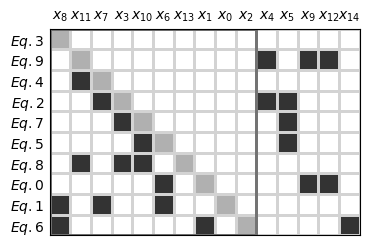

In [106]:
edgesopt, _, _ = eqv_to_edges_tree(edges_idxforopt[0], output_set=outset_opt)
Gopt = flat_graph_formulation(*edgesopt)
orderopt = sort_scc(Gopt, outputname=True)
treeopt = (OrderedDict([(elt,1) for scc in orderopt for elt in scc]),{},{})
render_incidence(edgesopt, treeopt, rotation=0, hideticks=True, dispendcomp=True, figsize=((4,4)), fontsize=10);

## Architectures

In [26]:
from torchengine import EliminateAnalysisMergeResiduals, ElimResidual, EliminateAnalysis, ParallelAnalysis
from torchdata import generate_optim_functions

### 1) AAO

In [27]:
eq = EliminateAnalysisMergeResiduals([], [s.residual for s in sets.values()])
dummy_function = Function(((), lambda : torch.tensor([])), indices)
ineq = res = dummy_function
optim_funcs_AAO = EliminateAnalysis([], [objective, ineq, eq, res])

In [28]:
solvefor_indices = optim_funcs_AAO.structure[0]
torch.manual_seed(43)
all_indices = torch.cat(list(indices.values()))
x0 = torch.rand_like(all_indices, dtype=torch.float64)
x0.requires_grad_(True)
optim_data = generate_optim_functions(optim_funcs_AAO, solvefor_indices, 
                         x0, inequality_direction='negative-null')
xguess, obj_function, _, eq_function, dobj, _, deq = optim_data
constraints = [{'type': 'eq', 'fun': eq_function, 'jac': deq}]

In [29]:
# eps = 10e-6
# (eq_function(xguess + eps*np.eye(15)[1])-eq_function(xguess))/eps

In [30]:
minimize(obj_function, xguess, jac=dobj, constraints=constraints, 
         method='SLSQP', options={'maxiter':1000})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.348424700615461e-08
       x: [ 9.999e-01  9.998e-01 ...  1.000e+00  9.997e-01]
     nit: 27
     jac: [-4.409e-04 -1.058e-03 ...  0.000e+00  0.000e+00]
    nfev: 33
    njev: 27

In [31]:
print_formatted_table([x0], indices, idxrev)

x_1 x_10 x_11 x_2 x_6 x_12 x_9 x_0 x_7 x_8 x_3 x_4 x_5 x_14 x_13
1   1    1    1   1   1    1   1   1   1   1   1   1   1    1   


In [32]:
n = len(solvefor_indices)
m = len(sets)

In [33]:
from collections import namedtuple
import cyipopt
OptProblem = namedtuple('OptProblem', ['objective', 'constraints', 'gradient', 'jacobian', 'intermediate'])

lb,ub = -np.inf*np.ones(n), np.inf*np.ones(n)
cl,cu = np.zeros(m), np.zeros(m)

storeiter = [0]

def logiter(alg_mod, iter_count, obj_value, inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
    storeiter[0] = iter_count

# define the problem
probinfo = OptProblem(obj_function, eq_function, dobj, deq, logiter)

prob = cyipopt.Problem(n=len(xguess), m=len(cu), lb=lb, ub=ub, cl=cl, cu=cu, 
                       problem_obj=probinfo)
# prob.add_option('mu_strategy', 'adaptive')
prob.add_option('tol', 1e-7)

In [35]:
# prob.solve(xguess)

In [36]:
storeiter[0]

2454

### 1b) Reduced AAO

In [137]:
equations = []
elimination = []
coupling_residuals = []
edges_out = edges[1]
edges_out = edgesopt[1]
useorder = orderopt
for elt in useorder:
    if len(elt) > 1: 
        groupsets = [sets[eqid] for eqid in elt]
        residuals = [s.residual for s in groupsets]
        equations += residuals
    else:
        eqid = next(iter(elt))
        aset = sets[eqid].reassign(idxrev[edges_out[eqid][0]], rational=True)
        if edges_out[eqid] == ():
            equations.append(aset.residual)
        else:
            elimination.append(aset.analysis)  

In [146]:
res = EliminateAnalysisMergeResiduals([], equations) if equations else dummy_function
dummy_function = Function(((), lambda : torch.tensor([])), indices)
optim_funcs_AAO_reduced = EliminateAnalysis(elimination, [objective, dummy_function, 
                                                          dummy_function, res])

In [147]:
solvefor_indices = optim_funcs_AAO_reduced.structure[0]
torch.manual_seed(43)
all_indices = torch.cat(list(indices.values()))
#x0 = 0.7*torch.ones_like(all_indices, dtype=torch.float64)
x0 = torch.rand_like(all_indices, dtype=torch.float64)
x0.requires_grad_(True)
optim_data = generate_optim_functions(optim_funcs_AAO_reduced, solvefor_indices, 
                         x0)
xguess, obj_function, _, eq_function, dobj, _, deq = optim_data
constraints = [{'type': 'eq', 'fun': eq_function, 'jac': deq}] if equations else None

In [148]:
EliminateAnalysis(elimination).structure_full

{8: [],
 11: [12, 4, 9],
 7: [12, 4, 9],
 3: [4, 5, 12, 9],
 10: [4, 5, 12, 9],
 6: [4, 5, 12, 9],
 13: [4, 5, 12, 9],
 1: [12, 4, 5, 9],
 0: [4, 5, 12, 9],
 2: [12, 4, 5, 9, 14]}

In [156]:
obj_function(xguess)

647.3764532370052

In [155]:
minimize(obj_function, xguess, jac=dobj, constraints=constraints, 
         method='SLSQP', options={'maxiter':1000})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6140543002281458
       x: [ 2.134e+01  4.164e+01  2.104e-01  2.004e+00 -1.366e+02]
     nit: 135
     jac: [-3.143e-02  1.518e-02  2.628e+00  5.186e-01  1.207e-04]
    nfev: 230
    njev: 135

In [158]:
from collections import namedtuple
import cyipopt
OptProblem = namedtuple('OptProblem', ['objective', 'constraints', 'gradient', 'jacobian', 'intermediate'])

n = len(solvefor_indices)
m = len(eq_function(xguess))
lb,ub = -np.inf*np.ones(n), np.inf*np.ones(n)
cl,cu = np.zeros(m), np.zeros(m)

storeiter = [0]

def logiter(alg_mod, iter_count, obj_value, inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
    storeiter[0] = iter_count

# define the problem
probinfo = OptProblem(obj_function, eq_function, dobj, deq, logiter)

prob = cyipopt.Problem(n=len(xguess), m=len(cu), lb=lb, ub=ub, cl=cl, cu=cu, 
                       problem_obj=probinfo)
# prob.add_option('mu_strategy', 'adaptive')
prob.add_option('tol', 1e-7)
prob.solve(xguess)

(array([1, 1, 1, 1, 1]),
 {'x': array([1, 1, 1, 1, 1]),
  'g': array([], dtype=float64),
  'obj_val': 5.633725109689704e-12,
  'mult_g': array([], dtype=float64),
  'mult_x_L': array([0, 0, 0, 0, 0]),
  'mult_x_U': array([0, 0, 0, 0, 0]),
  'status': 0,
  'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'})

In [159]:
print(storeiter[0])

86


### 2) Reduced MDF with residuals

In [160]:
from collections import OrderedDict
from graph.matrixview import render_incidence

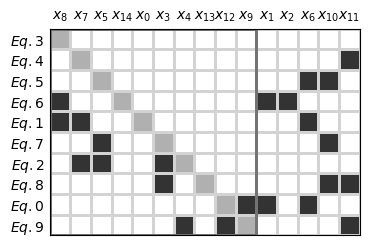

In [161]:
tree = (OrderedDict([(elt,1) for scc in order for elt in scc]),{},{})
render_incidence(edges, tree, rotation=0, hideticks=True, dispendcomp=True, figsize=((4,4)), fontsize=10);

In [162]:
equations = []
elimination = []
coupling_residuals = []
edges_out = edges[1]
edges_out = edgesopt[1]
useorder = orderopt
for elt in useorder:
    if len(elt) > 1: # solve group
        groupsets = [sets[eqid] for eqid in elt]
        residuals = [s.residual for s in groupsets]
        coupled = EliminateAnalysisMergeResiduals([], residuals)
        coupling_residuals.append(coupled)
        coupledvars = [s.outputvar for s in groupsets]
        solver = ElimResidual(coupled, coupledvars, indices) #indices
        elimination.append(solver)
        # alterantively we could add them to elimination
    else:
        eqid = next(iter(elt))
        aset = sets[eqid].reassign(idxrev[edges_out[eqid][0]], rational=True)
        if edges_out[eqid] == ():
            equations.append(aset.residual)
        else:
            elimination.append(aset.analysis)  

In [163]:
x0 = torch.rand_like(all_indices, dtype=torch.float64)

In [164]:
idx=2
elimination[idx](x0);

In [165]:
elimination[idx].structure

(tensor([11]), tensor([7]))

In [166]:
x0.requires_grad_(True)
torch.autograd.functional.jacobian(elimination[idx], torch.ones(15))[:,1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [167]:
eps = 10e-3
(elimination[idx](torch.ones(15) + eps*torch.eye(15)[1])-elimination[idx](torch.ones(15)))/eps

tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [168]:
idx = 2
print(elimination[idx].structure)
# print_formatted_table([x0, elimination[idx](x0)], indices, idxrev)

(tensor([11]), tensor([7]))


In [169]:
print_formatted_table([x0], indices, idxrev)

x_1   x_10  x_11 x_2   x_6   x_12  x_9   x_0   x_7   x_8   x_3      x_4   x_5   x_14 x_13 
0.418 0.596 0.96 0.366 0.561 0.258 0.913 0.667 0.252 0.792 5.21e-03 0.924 0.627 0.2  0.311


In [170]:
elimination[idx](x0);

In [171]:
print_formatted_table([x0], indices, idxrev)

x_1   x_10  x_11 x_2   x_6   x_12  x_9   x_0   x_7   x_8   x_3      x_4   x_5   x_14 x_13 
0.418 0.596 0.96 0.366 0.561 0.258 0.913 0.667 0.252 0.792 5.21e-03 0.924 0.627 0.2  0.311


In [172]:
MDAreduced = EliminateAnalysis(elimination, [])

In [173]:
optim_funcs_reduced_MDF = EliminateAnalysis(elimination, [objective, dummy_function, dummy_function, dummy_function])

In [174]:
x0 = torch.rand_like(all_indices, dtype=torch.float64)

In [175]:
MDAreduced(x0)

tensor([0.7639, 0.2393, 0.1802, 0.6008, 0.3621, 0.9413, 1.6643, 0.7866, 1.0000,
        0.5131, 1.7681, 1.2713, 0.5551, 2.3146, 0.7533], dtype=torch.float64)

In [176]:
solvefor_indices = optim_funcs_reduced_MDF.structure[0]
torch.manual_seed(43)
all_indices = torch.cat(list(indices.values()))
x0 = torch.rand_like(all_indices, dtype=torch.float64)
x0.requires_grad_(True)
optim_data = generate_optim_functions(optim_funcs_reduced_MDF, solvefor_indices, x0)
xguess, obj_function, _, _, dobj, _, _ = optim_data

In [177]:
minimize(obj_function, xguess, jac=dobj, 
         method='SLSQP', options={'maxiter':1000})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6140543002281458
       x: [ 2.134e+01  4.164e+01  2.104e-01  2.004e+00 -1.366e+02]
     nit: 135
     jac: [-3.143e-02  1.518e-02  2.628e+00  5.186e-01  1.207e-04]
    nfev: 230
    njev: 135

In [178]:
print_formatted_table([x0, MDAreduced(x0)], indices, idxrev)

x_1       x_10  x_11  x_2   x_6   x_12   x_9   x_0   x_7   x_8  x_3   x_4    x_5  x_14     x_13
0.368     0.858 0.592 0.185 0.153 21.337 2.004 0.632 0.3   0.42 0.728 41.636 0.21 -136.564 0.5 
-7.26e-03 1.118 0.974 0.992 0.235 21.337 2.004 4.138 1.027 1    4.25  41.636 0.21 -136.564 0.27


### 3) Strict MDF

In [179]:
from torchengine import ipoptsolver
from functools import partial
all_analysis = {idx: s.analysis for idx, s in sets.items()}
coupledvars = torch.cat([a.structure[1] for a in all_analysis.values()])
residual_eqs = ParallelAnalysis(all_analysis.values(), [], 
                           sharedvars=coupledvars) #Jacobi/Newton

#bnds = [(None, None) for _ in coupledvars]
#ipsolver = partial(ipoptsolver, bnds_problem=bnds, debug=True)
MDAsolver = ElimResidual(residual_eqs, coupledvars, 
                         indices, solvefor_raw=True)
optim_funcs_strict_MDF = EliminateAnalysis([MDAsolver], [objective, dummy_function, dummy_function, dummy_function])

In [180]:
optim_indices = optim_funcs_strict_MDF.structure[0]
torch.manual_seed(43)
all_indices = torch.cat(list(indices.values()))
#0 = torch.rand_like(all_indices, dtype=torch.float64)
x0 = 0.7*torch.ones_like(all_indices, dtype=torch.float64)
x0.requires_grad_(True)
optim_data = generate_optim_functions(optim_funcs_strict_MDF, optim_indices, x0)
xguess, obj_function, _, _, dobj, _, _ = optim_data

In [181]:
minimize(obj_function, xguess, jac=dobj, 
         method='SLSQP', options={'maxiter':1000})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 3
    njev: 2

In [182]:
MDAsolver(x0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64, grad_fn=<ElimResidualFuncBackward>)

In [183]:
print_formatted_table([residual_eqs(x0)], 
                      {idxrev[k.structure[1][0].item()]:torch.tensor([idx]) for idx,k in enumerate(all_analysis.values())}, 
                      {idx:idxrev[k.structure[1][0].item()] for idx, k in enumerate(all_analysis.values())})

x_12   x_0    x_4    x_8    x_7    x_5    x_14   x_3    x_13   x_9   
0.00e0 0.00e0 0.00e0 0.00e0 0.00e0 0.00e0 0.00e0 0.00e0 0.00e0 0.00e0


### 4) Strict IDF

In [71]:
all_analysis = {idx: s.analysis for idx, s in sets.items()}
coupledvars = torch.cat([a.structure[1] for a in all_analysis.values()])
optim_funcs_strict_IDF = ParallelAnalysis(all_analysis.values(), [objective, dummy_function, dummy_function], 
                           sharedvars=coupledvars) 


In [72]:
solvefor_indices = optim_funcs_strict_IDF.structure[0]
torch.manual_seed(43)
all_indices = torch.cat(list(indices.values()))
x0 = 0.7*torch.ones_like(all_indices, dtype=torch.float64)
x0.requires_grad_(True)
optim_data = generate_optim_functions(optim_funcs_strict_IDF, solvefor_indices, 
                         x0)
xguess, obj_function, _, eq_function, dobj, _, deq = optim_data
constraints = [{'type': 'eq', 'fun': eq_function, 'jac': deq}]

In [73]:
minimize(obj_function, xguess, jac=dobj, constraints=constraints,
         method='SLSQP', options={'maxiter':1000})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.440984528205472e-09
       x: [ 1.000e+00  1.000e+00 ...  9.999e-01  1.000e+00]
     nit: 12
     jac: [ 1.902e-05 -1.240e-04 ...  0.000e+00  0.000e+00]
    nfev: 13
    njev: 12